# Project: Navigation
---
In this notebook, you will implement a DQN agent to solve Unity Environment's Banana Collector environment.

### 1. Import necessary packages
Here we import some basic libraries such as Numpy, torch, datetime, namedtuple, deque, and matplotlib. We also import UnityEnvironment that will allow us to interact with the Banana Environment.

In [1]:
import random
import torch
import numpy as np
import datetime
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

from unityagents import UnityEnvironment

### 2. Instantiate the Environment
Next, we will start the environment!  **_Before running the code cell below_**, change the `Environment_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Windows, then you downloaded `Banana.exe`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
Environment_name = "Banana.exe"
```

In [2]:
Environment_name = "..\Banana_Windows_x86_64\Banana.exe"
env = UnityEnvironment(file_name=Environment_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)
print(brain)

BananaBrain
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Explore the Environment
The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 4. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  


In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 5. Build Our Deep Q-Network

The Neural Network model we are going to use consists of fully connected layers only.


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, action_size)
        

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

### 6. Build Our DQN Agent

We define a class called `ReplayBuffer` that holds the memory of past experiences.


In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

- The agent will use the model we built to make 2 identical Neural Networks:
    1. Local Neural Network: This will be updated every epoch
    1. Target Neural Network: This will be soft-updated with the value of the local neural network


- The hyper parameters in the agent will be:
    1. `BUFFER_SIZE` - Size of the pool of past experiences the agent will choose from
    1. `BATCH_SIZE` - Minibatch size
    1. `GAMMA` - Discount factor &gamma;
    1. `TAU` - Soft updae parameter &tau;
    1. `LR` - Learning rate parameter
    1. `UPDATE_EVERY` - Number of timesteps required before an update to the network 

In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        """Saves an experience and executes learn.
        
        Params
        ======
            state (array_like): current state
            action (array_like): current action
            reward (array_like): current reward
            next_state (array_like): next state
            done (array_like): a flag to indicate if the current state is terminal
        """
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        self.optimizer.zero_grad()
        
        # Double Q-Learning
        actions_local = torch.argmax(self.qnetwork_local(next_states).detach(), dim=1).unsqueeze(1)
        actions_target = self.qnetwork_target(next_states).detach().gather(1, actions_local)
        targets = rewards + gamma * actions_target
        
        predictions = self.qnetwork_local(states).gather(1, actions)
            
        loss = F.mse_loss(targets, predictions)
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### 7. Train the Agent

Define a function `dqn` that trains the agent.


In [9]:
def dqn(env, agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, max_score=13):
    """Deep Q-Learning.
    
    Params
    ======
        env (Environment_variable) : an instance of the enivronment class
        agent (agent_variable) : an instance of the agent class
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        max_score (int): the maximum average reward over 100 episodes at which the training stops
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    brain_name = env.brain_names[0]
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                 # choose the apropriate action
            action = action.astype('int32')                # convert action to type int32 to be compaitable with Unity-Env
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if i_episode % 1000 == 0:
            torch.save(agent.qnetwork_local.state_dict(), "checkpoint.pth")
        if np.mean(scores_window)>=max_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), "checkpoint.pth")
            break
    return scores

Run the cell below to begin training

Episode 100	Average Score: 0.44
Episode 200	Average Score: 4.30
Episode 300	Average Score: 8.10
Episode 400	Average Score: 10.01
Episode 500	Average Score: 12.97
Episode 501	Average Score: 13.04
Environment solved in 501 episodes!	Average Score: 13.04


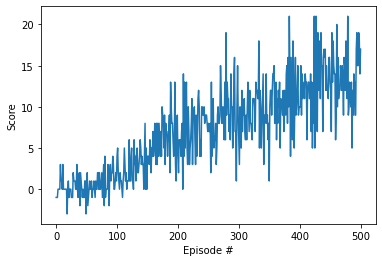

In [10]:
# Choose default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Determine state and action sizes
env_info = env.reset(train_mode=False)[brain_name]
state_size = len(env_info.vector_observations[0])
action_size = brain.vector_action_space_size

# Instatiate the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

# Define training parameters
n_episodes=2000        # maximum number of training episodes
max_t=int(1e5)         # maximum number of timesteps per episode
eps_start=1.0          # starting value of epsilon, for epsilon-greedy action selection
eps_end=0.01           # minimum value of epsilon
eps_decay=0.995        # multiplicative factor (per episode) for decreasing epsilon
max_score=13           # the maximum average reward over 100 episodes at which the training stops

# Begin training
scores = dqn(env, agent, n_episodes=n_episodes, max_t=max_t, eps_start=eps_start,
             eps_end=eps_end, eps_decay=eps_decay, max_score=max_score)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 8. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!
Copy the name of the file holding the weights into the variable `saved_weights_file`. There are 2 checkpoints provided in this project: `checkpoint.pth` we just saved from the previous cell, and `BestCheckpoint.pth` which is the result of a 2000 episodes run giving an average score of `15.82`.

In [12]:
# load the weights from file
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'
saved_weights_file = "BestCheckpoint.pth"
agent.qnetwork_local.load_state_dict(torch.load(saved_weights_file, map_location=map_location))

max_episodes = 100
max_time = 100000
score_board = []

for i in range(max_episodes):
    score = 0
    env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
    state = env_info.vector_observations[0]             # get the current state
    for j in range(max_time):
        action = agent.act(state)                      # choose the apropriate action
        action = action.astype('int32')                # convert action to type int32 to be compaitable with Unity-Env
        env_info = env.step(action)[brain_name]        # send the action to the environment
        reward = env_info.rewards[0]                   # get the reward
        next_state = env_info.vector_observations[0]   # get the next state
        state = next_state
        score += reward
        done = env_info.local_done[0]                  # see if episode has finished
        if done:
            break
    print("Episode {}\tScore: {}".format(i + 1, score))
    score_board.append(score)
print("Score Average = {}".format(np.mean(score_board)))

Episode 1	Score: 17.0
Episode 2	Score: 19.0
Episode 3	Score: 13.0
Episode 4	Score: 19.0
Episode 5	Score: 14.0
Episode 6	Score: 15.0
Episode 7	Score: 21.0
Episode 8	Score: 15.0
Episode 9	Score: 20.0
Episode 10	Score: 13.0
Episode 11	Score: 13.0
Episode 12	Score: 21.0
Episode 13	Score: 4.0
Episode 14	Score: 15.0
Episode 15	Score: 21.0
Episode 16	Score: 21.0
Episode 17	Score: 0.0
Episode 18	Score: 18.0
Episode 19	Score: 16.0
Episode 20	Score: 18.0
Episode 21	Score: 20.0
Episode 22	Score: 24.0
Episode 23	Score: 10.0
Episode 24	Score: 7.0
Episode 25	Score: 9.0
Episode 26	Score: 17.0
Episode 27	Score: 16.0
Episode 28	Score: 1.0
Episode 29	Score: 17.0
Episode 30	Score: 15.0
Episode 31	Score: 10.0
Episode 32	Score: 18.0
Episode 33	Score: 16.0
Episode 34	Score: 23.0
Episode 35	Score: 22.0
Episode 36	Score: 11.0
Episode 37	Score: 13.0
Episode 38	Score: 13.0
Episode 39	Score: 19.0
Episode 40	Score: 18.0
Episode 41	Score: 20.0
Episode 42	Score: 10.0
Episode 43	Score: 18.0
Episode 44	Score: 20.0
Ep